# Object Detection with SSD
### Here we demonstrate detection on example images using SSD with PyTorch

In [81]:
import os
import sys
module_path = os.path.abspath(os.path.join('../ssd_pytorch/'))
if module_path not in sys.path:
    sys.path.append(module_path)

home = os.path.expanduser("~")
ddir = os.path.join(home,"data/invasive/")

cwd = os.getcwd()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.serialization import load_lua
from PIL import Image, ImageOps
import numpy as np
#import cv2 
import ssd
import matplotlib
import random
import torchvision.utils
import matplotlib.pyplot as plt

random.seed(123)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
def create_sets(anno_dir, set_dir):
    train = []
    val = []
    for root, _, fnames in os.walk(anno_dir):
        for fname in fnames:
            id = fname.split('.xml')[0]
            if random.randint(0,3) == 3: # 1/5 go to validation set
                val.append(id)
            else:
                train.append(id)
    with open(os.path.join(set_dir, "train.txt"), 'w+') as train_file:
        train_file.writelines('\n'.join(train))
    with open(os.path.join(set_dir, "val.txt"), 'w+') as val_file:
        val_file.writelines('\n'.join(val))

create_sets(os.path.join(ddir,'Annotations'), os.path.join(ddir,'ImageSets'))

In [79]:
def copy_anno_images(anno_dir, img_dir, dest_dir):
    if not os.path.isdir(dest_dir):
        os.mkdir(dest_dir)
    for root, _, fnames in os.walk(anno_dir):
        for fname in fnames:
            id = fname.split('.xml')[0]
            img_id = id+".jpg"
            os.system('cp '+os.path.join(img_dir,img_id)+' '+os.path.join(dest_dir,img_id))

copy_anno_images(os.path.join(ddir,'Annotations'), os.path.join(ddir,'JPEGImages', 'train_resized'), os.path.join(ddir,'JPEGImages', 'train_resized_small'))

In [34]:
# imports needed if running locally
#from PIL import Image, ImageOps
#import os

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def resize_images(image_dir, dest_dir):
    if not os.path.isdir(dest_dir):
        os.mkdir(dest_dir)
    for root, _, fnames in os.walk(image_dir):
        for fname in fnames:
            if is_image_file(fname):
                img = pil_loader(os.path.join(root,fname))
                img = img.resize((300,300), Image.LANCZOS)
                img.save(os.path.join(dest_dir, fname))

resize_images(os.path.join(ddir,'JPEGImages','train'), os.path.join(ddir,'JPEGImages','train_resized'))

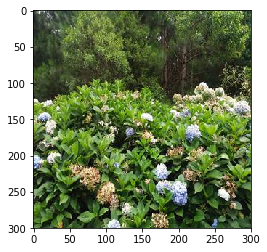

In [35]:
img = pil_loader(os.path.join(ddir,'JPEGImages','train_resized', '1010.jpg'))
plt.imshow(img)

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (2 for Hydrangea dataset)

In [3]:
model = ssd.build_ssd('train', 300, 2)    # initialize SSD
#net.load_weights('./weights/ssd_300_VOC0712.pth')


## Load Image 
### Here we just load a sample image from the Hydrangea dataset 

In [9]:
import torchvision.utils
import matplotlib.pyplot as plt

to_pil = torchvision.transforms.ToPILImage()

def show_img(inp):
    print(inp.size())
    img = to_pil(inp)
    plt.imshow(img)

torch.Size([3, 300, 300])


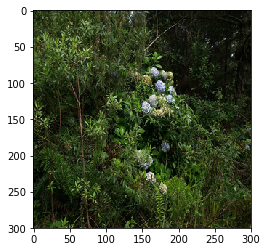

In [10]:
inputs, classes = next(iter(dset_loaders['train']))
show_img(inputs[0])

In [13]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [98]:
from TrainSSD import SSDSolver

model = ssd.build_ssd('train', 300, 2)
SSDSolver(model, batch_size=1).train()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /b/wheel/pytorch-src/torch/lib/THC/generic/THCStorage.cu:66

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

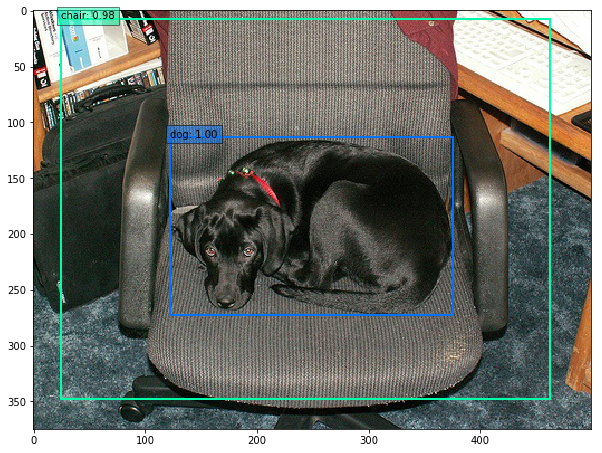

In [7]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor([rgb_image.shape[1::-1], rgb_image.shape[1::-1]])
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1